# <center> Оценка качестве uplift-моделирования. Практика

**Общая постановка задачи:**

Представим, что мы решаем задачу удержания клиенту либо с помощью скидок, либо с помощью промо-механик . 

В нашем распоряжении будут результаты некоторой маркетинговой компании, в которой клиентам предлагались скидки и промоакции (в данном случае использовалась промо-акция "Buy One Get One" - "Купи один товар, получи второй в подарок"). 

На основе результатов маркетинговой компании нам необходимо будет провести uplift-моделирование и оценить uplift-эффект для каждого уникального клиента, чтобы в дальнейшем в автоматическом режиме проводим сегментацию клиентов и повышать эффективность маркетинговой компании. 

В рамках данной практики нам предстоит научиться оценивать качество нашей uplift-модели! 

> В нашем распоряжении будет два датасета с предсказаниями некоторых uplift-моделей. Нам необходимо будет реализовать функционал для построения quni-curve и рассчета quni-score и оценить качество uplift-моделирования. 

Импортируем необходимые библиотеки и загрузим семплы данных (данные о результатах воздействия скидками и промоакциями).

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Прочитаем файлы с данными

# Читаем файл с результатами uplift-моделирования на данных о скидках
df_discount = pd.read_csv('data_discount_uplift.csv')
# Читаем файл с результатами uplift-моделирования на данных о промоакциях
df_bogo = pd.read_csv('data_bogo_uplift.csv')

Посмотрим на данные поближе:

In [ ]:
print('Data discount shape: {}'.format(df_discount.shape))
df_discount.head()

Data discount shape: (42613, 15)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,uplift_score
0,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1,0.093915
1,9,675.83,1,0,1,1,2,0,1,0,0,0,0,1,0.072600
2,9,675.07,1,1,1,1,2,0,1,0,0,0,1,0,0.083439
3,2,101.64,0,1,0,1,3,1,0,0,1,0,0,1,0.077655
4,4,241.42,0,1,1,0,0,0,1,0,0,1,0,0,0.074123


In [ ]:
print('Data discount shape: {}'.format(df_bogo.shape))
df_bogo.head()

Data discount shape: (42693, 15)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,uplift_score
0,10,142.44,1,0,0,1,2,0,0,1,0,0,1,0,0.006968
1,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1,0.022530
2,7,180.65,0,1,1,1,2,0,0,1,0,0,0,1,0.077381
3,2,45.34,1,0,0,1,2,0,0,0,1,0,0,1,0.027151
4,6,134.83,0,1,0,1,3,1,0,1,0,0,1,0,0.074412


Структура предоставленных таблиц идентична. Каждая строка в таблице отвечает за  признаки, характеризующие некоторого конкретного пользователя. 

С более детальным описанием признаков в данных мы познакомимся позже. Сейчас для нас важны 4 следующих признака в данных:
* **treatment**  - фактор целевого воздействия (1 - было воздействие, 0 - воздействия не было)

    Для данных о скидках 1 означает, что клиенту была предложена скидка
    
    Для данных о промоакциях 1 означает, что клиенту была предложена промоакция

* **conversion** - признак конверсии (1 - купил, 0 - не купил)

* **target_class** - класс клиента (вспомогательный признак):
    * **0 - Control Non-Responders(CN)** 

        Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
    * **1 - Control Responders(CR)**

        Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
    * **2 - Treatment Non-Responders(CN)**

        Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    * **3 - Treatment Responders(CN)** 
        
        Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

* **uplift_score** - uplift-эффект, предсказанный некоторой моделью машинного обучения для конкретного клиента

Нашей задачей в рамках данной практики является реализовать функцию для построения quni-curve и рассчета quni-score. 

## Работаем с данными о скидках

### Quni-curve и qini-score

Создадим функцию для построения qini-curve и расчета qini-score. Она будет принимать на вход некоторый DataFrame, в котором должны содержаться признаки uplift_score (uplift-эффект) и target_class (класс пользователя). 

In [ ]:
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

Построим qini-curve и рассчитаем qini-score для данных о скидках.

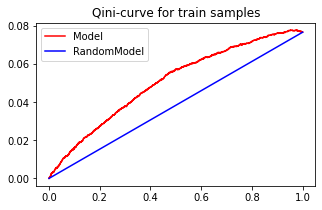

Qini score: 514.117


In [ ]:
qini_df(df_discount)

## Работаем с данными о промоакциях

Теперь вам предстоит самостоятельно оценить результаты uplift-моделирования на данных о промоакциях. 

**Задание №1**

Рассчитайте qini-score для результатов uplift-моделирования на данных о промоакциях (df_bogo) с точностью до третьего знака после запятой. Полученный результат запишите в качестве ответа.

In [ ]:
# ваш код здесь

**Задание №2**

Найдите ординату (координату по оси y) у крайней точки случайной кривой по датасету о промоакциях (df_bogo) с точностью до третьего знака после запятой.

In [ ]:
# ваш код здесь